# Data analysis with Neo4j and python for RESIDE_IN data

## Imports

In [1]:
from py2neo import Graph, Database

In [2]:
from neo4j import GraphDatabase

In [3]:
from tabulate import tabulate

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [5]:
import seaborn as sns
sns.set();
sns.color_palette("colorblind");

In [6]:
%matplotlib inline

In [7]:
from scipy import stats
import numpy as np

## Conect to database:

In [8]:
uri = 'bolt://neo4j-hdx:7687'

## Py2neo

In [9]:
default_db = Database(uri, auth=("neo4j", "test"))

In [10]:
default_db.name

'graphHDX.db'

Default graph in the database:

In [11]:
default_db.default_graph.name

'data'

Instanciate a Graph object conecting to the default graph 'data' exposed in 'graphHDX.db':

In [12]:
graph = Graph(uri, auth=("neo4j", "test"))

In [13]:
graph.database.name

'graphHDX.db'

Get the number of nodes in the graph:

In [14]:
len(graph.nodes)

7376

Get the number of relationship in the graph:

In [15]:
len(graph.relationships)

124501

Explore the Schema of the graph:

 - Nodes

In [16]:
graph.schema.node_labels

frozenset({'Country', 'CountryYear'})

 - Relationships

In [17]:
rel_types = graph.schema.relationship_types

In [18]:
len(rel_types)

59

In [19]:
list(rel_types)[0:5]

['1995', '1996', '1999', '1968', '1992']

Relationship between CountryYear nodes:

In [20]:
[rel for rel in graph.schema.relationship_types if not rel.isdigit()]

['RESIDE_IN']

Get all years with available data from the relationship_types:

In [21]:
years_list = [rel for rel in graph.schema.relationship_types if rel.isdigit()]
years_list.sort()

In [22]:
years_list[0:5]

['1960', '1961', '1962', '1963', '1964']

Get all possible countries with all years that have data available:

In [23]:
nodes_country_year_list = list(graph.nodes.match("CountryYear"))

The total number of the combinations between countries and years with data available is:

In [24]:
len(nodes_country_year_list)

7154

Let's define a funtion to print in table format all countries with available World Bank Indicators for a given year:

In [25]:
def print_table_country_indicators_given_year(year, nodes_country_year):
    
    print(tabulate([{ key : element[key] for key in ["year", 
                                                     "country",
                                                     "population",
                                                     "pop_growth_percentage", 
                                                     "urban_pop_percentage", 
                                                     "int_migrant_stock" ] } for element in nodes_country_year if element["year"] == year], 
                       headers="keys",
                       stralign='center',
                       floatfmt='.0f'))

In [26]:
print_table_country_indicators_given_year(2017, nodes_country_year_list)

  year                   country                     population    pop_growth_percentage    urban_pop_percentage   int_migrant_stock
------  -----------------------------------------  ------------  -----------------------  ----------------------  -------------------
  2017                  Bulgaria                        7075991                       -1                      75
  2017                    Spain                        46572028                        0                      80
  2017                   Uganda                        42862960                        3                      23
  2017            Sao Tome and Principe                  204327                        2                      72
  2017                 Cabo Verde                        546388                        1                      65
  2017                   Somalia                       14742523                        3                      44
  2017                Cote d'Ivoire                    

In [27]:
print_table_country_indicators_given_year(2013, nodes_country_year_list)

  year                   country                     population    pop_growth_percentage    urban_pop_percentage   int_migrant_stock
------  -----------------------------------------  ------------  -----------------------  ----------------------  -------------------
  2013                  Bulgaria                        7265115                       -1                      73
  2013                    Spain                        46620044                       -0                      79
  2013                   Uganda                        37553728                        3                      21
  2013            Sao Tome and Principe                  187045                        2                      68
  2013                 Cabo Verde                        520106                        1                      63
  2013                   Somalia                       13132349                        3                      42
  2013                Cote d'Ivoire                    

## Neo4j driver

Conect to the database using the driver class GraphDatabase 

In [28]:
driver = GraphDatabase.driver(uri, auth=("neo4j", "test"))

### Yearly evolution of the total number of population of concern

Define a query that calculates the sum of all population of concern in the world for a given year:

In [29]:
def total_pop_concern_given_year(tx, year):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->(b:CountryYear) "
                        "WHERE a.year={0} AND b.year={0} " 
                        "RETURN a.year as year, sum(r.affected_total) as affectedTotal, "
                        "sum(r.affected_refugees) as affectedRefugees, "
                        "sum(r.affected_asylum) as affectedAsylum, "
                        "sum(r.affected_idps) as affectedIdps".format(year)) 

Iterate t

In [30]:
with driver.session() as session:
    out_total_pop = []
    for year in years_list[0::1]:
        [out_total_pop.append(element) for element in session.read_transaction(total_pop_concern_given_year, year).data()]

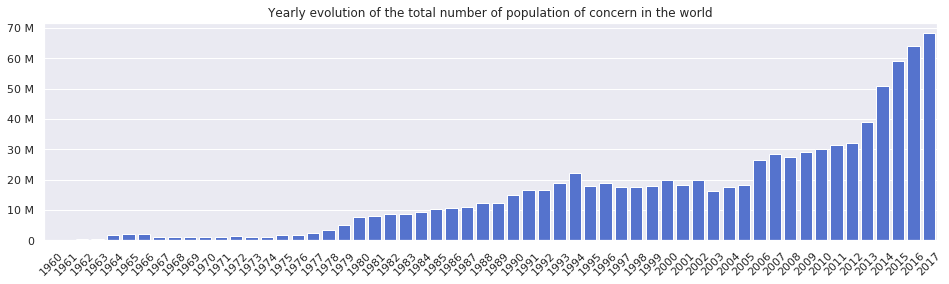

In [31]:
plt.figure(figsize=(16,4))
ax = sns.barplot(x=[data['year'] for data in out_total_pop], 
                 y=[data['affectedTotal'] for data in out_total_pop],
                 color='royalblue')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.xticks(rotation=45)
plt.title("Yearly evolution of the total number of population of concern in the world");

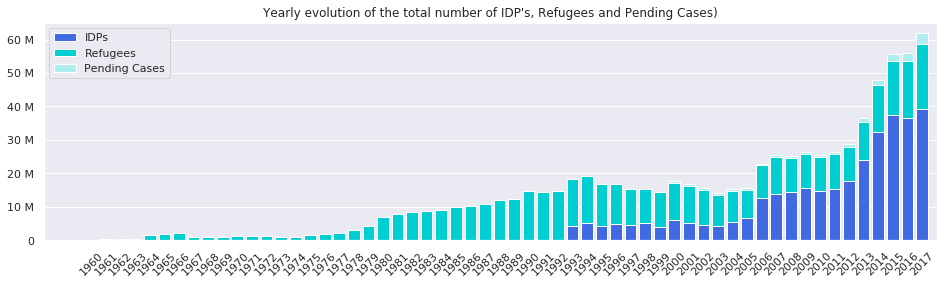

In [32]:
fig, ax = plt.subplots(figsize=(16,4))

x_data=[data['year'] for data in out_total_pop]
y1_data=[data['affectedIdps'] for data in out_total_pop]
y2_data=[data['affectedRefugees'] for data in out_total_pop]
y3_data=[data['affectedAsylum'] for data in out_total_pop]

y_temp = [sum(x) for x in zip(y1_data, y2_data)]

p1 = plt.bar(x_data, y1_data, color='royalblue')
p2 = plt.bar(x_data, y2_data, color='darkturquoise', bottom=y1_data)
p3 = plt.bar(x_data, y3_data, color='paleturquoise', bottom=y_temp )

plt.xlim(right=2018)
plt.legend((p1[0], p2[0], p3[0]), ('IDPs', 'Refugees', 'Pending Cases'))
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.xaxis.grid(False)
plt.xticks(x_data)
plt.xticks(rotation=45)

plt.title("Yearly evolution of the total number of IDP's, Refugees and Pending Cases)");

### Countries with the highest/lowest accumulated total number of people of concern residing_in/originating_from through the years

Define a query that creates a subgraph with data from a certain year and sums the property value affected_total of all relationships that exit/enter (originate_from/reside_in) a node, and orders by this value in descending mode returning the country, the total and total_affected summed value of the firstfive results:

In [33]:
def top_total_reside_in(tx, year, top_number, desc_flag):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]-() "
                         "WHERE a.year={0} " 
                         "RETURN a.country as country, a.year as year, sum(r.affected_total) as affectedTotal, sum(r.affected_refugees) as affectedRefugees "
                         "ORDER BY affectedTotal {2} LIMIT {1} ".format(year, top_number, desc_flag)) 

In [34]:
def top_total_originate_from(tx, year, top_number, desc_flag):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->() "
                         "WHERE a.year={0} " 
                         "RETURN a.country as country, a.year as year, sum(r.affected_total) as affectedTotal, sum(r.affected_refugees) as affectedRefugees "
                         "ORDER BY affectedTotal {2} LIMIT {1} ".format(year, top_number, desc_flag))


Execute queries on Neo4j and store results in python list:

In [35]:
top_number_limit_C1 = 3
top_number_limit_C2 = 1

In [36]:
with driver.session() as session:
    out_residing_highest = []
    out_originating_highest = []
    out_residing_lowest = []
    out_originating_lowest = []
    for year in years_list[0::1]:
        [out_residing_highest.append(element) for element in session.read_transaction(top_total_reside_in, year, top_number_limit_C1, "DESC").data()]
        [out_originating_highest.append(element) for element in session.read_transaction(top_total_originate_from, year, top_number_limit_C1, "DESC").data()]
        [out_residing_lowest.append(element) for element in session.read_transaction(top_total_reside_in, year, top_number_limit_C2, "").data()]
        [out_originating_lowest.append(element) for element in session.read_transaction(top_total_originate_from, year, top_number_limit_C2, "").data()]

Define ploting functions:

In [37]:
def plot_top_total_countries(data_list, rel_type, top_number_limit ):
    plt.figure(figsize=(14,9))
    ax = sns.scatterplot(x=[data['year'] for data in data_list], 
                         y=[data['affectedTotal'] for data in data_list], 
                         hue=[data['country'] for data in data_list],
                         size=[data['affectedRefugees'] for data in data_list],
                         sizes=(30, 300), palette='hls')
    ax.set_title("Top {0} countries where the highest number of population of concern have {1} through the years.\n " 
                 "Size of bubble represents the number of refugees".format(top_number_limit, rel_type))
    ax.set_ylabel('Affected Total')
    ax.set_xlabel('Year')
    ax.yaxis.set_major_formatter(ticker.EngFormatter())

In [38]:
def plot_country_lowest_total(data_list, rel_type):
    plt.figure(figsize=(16,4))
    ax = sns.barplot(x=[data['country-year'] for data in data_list], 
                     y=[data['affectedTotal'] for data in data_list],
                     color='darkturquoise')
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set(ylim=(0, 100))
    plt.xticks(rotation=45, ha='right')
    plt.title("Country with the least number of people of concern {0} it for every given year".format(rel_type));

 - Countries with the highest number of population of concern Resisding in them:

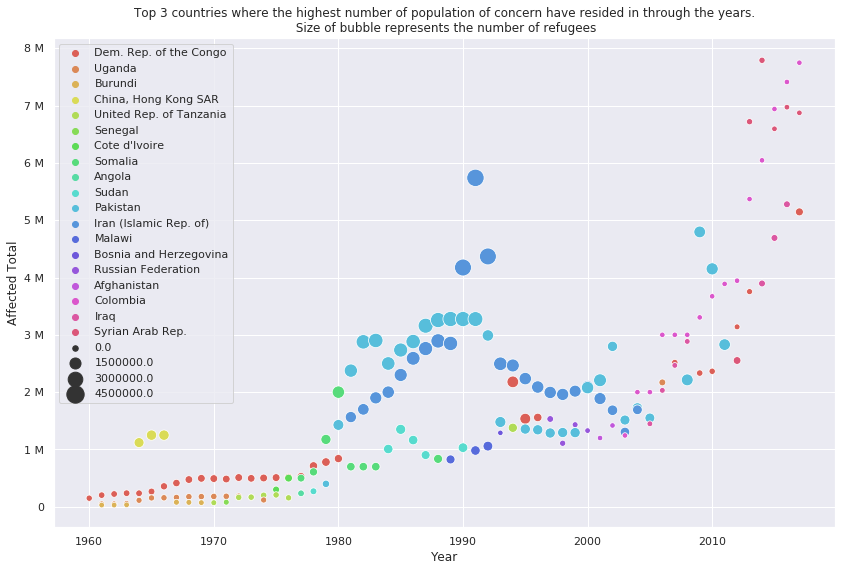

In [39]:
plot_top_total_countries(out_residing_highest, "resided in", top_number_limit_C1 )

 - Countries with the highest number of population of concern Originating from them:

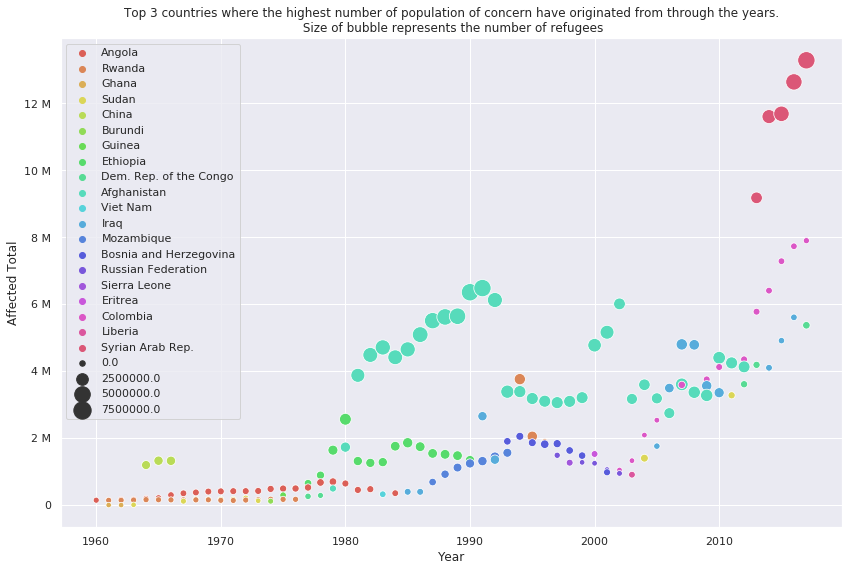

In [40]:
plot_top_total_countries(out_originating_highest, "originated from", top_number_limit_C1 )

Top 10 countries with the highest number of population of concern originationg from them for the past 3 years:

In [41]:
top_number_limit_C3 = 10
year_C3 = 2017
years_C3 = ['2017', '2016', '2015']

In [42]:
with driver.session() as session:
    top_originating_highest_2017 = session.read_transaction(top_total_originate_from, year_C3, top_number_limit_C3, "DESC").data()
    countries_top_originating_highest_2017 = [data['country'] for data in top_originating_highest_2017]

In [43]:
def total_pop_concern_given_year_and_country_origin(tx, year, country):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->() "
                        "WHERE a.year={0} AND a.country={1} " 
                        "RETURN a.year as year, a.country as country, "
                        "sum(r.affected_total) as affectedTotal".format(year,country)) 

In [44]:
with driver.session() as session:   
    out_total_pop_top_10 = []
    for country in countries_top_originating_highest_2017:
        for year in years_C3:
            [out_total_pop_top_10.append(element) for element in session.read_transaction(total_pop_concern_given_year_and_country_origin, 
                                                                                          year, '"' + country + '"').data()]

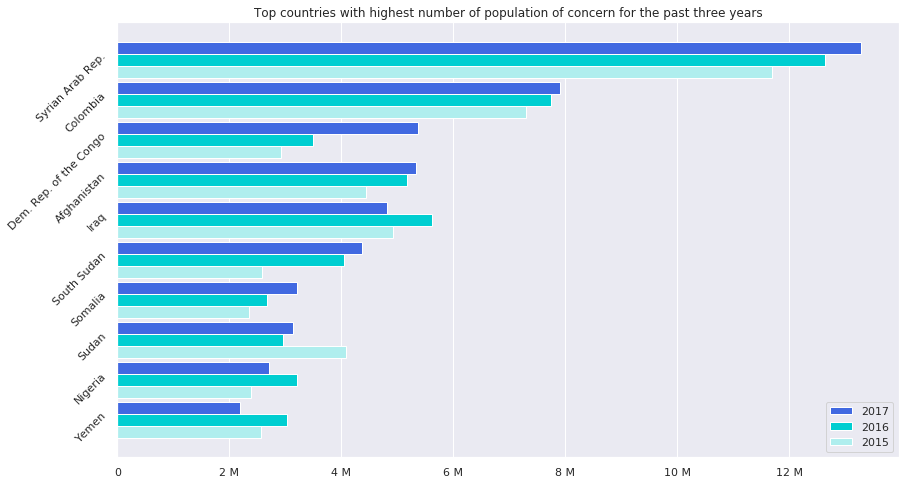

In [45]:
fig, ax = plt.subplots(figsize=(14,8));

data_2017 = [int(data['affectedTotal'] or 0) for data in out_total_pop_top_10 if data['year']==2017]
data_2016 = [int(data['affectedTotal'] or 0) for data in out_total_pop_top_10 if data['year']==2016]
data_2015 = [int(data['affectedTotal'] or 0) for data in out_total_pop_top_10 if data['year']==2015]

ind = np.arange(len(countries_top_originating_highest_2017))
width = 0.3      

plt.barh(ind , data_2017, width, label='2017', color='royalblue')
plt.barh(ind + width, data_2016, width, label='2016', color='darkturquoise')
plt.barh(ind+ 2*width, data_2015, width, label='2015', color='paleturquoise')

plt.title('Top countries with highest number of population of concern for the past three years')

ax.invert_yaxis()  # labels read top-to-bottom
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.grid(False)

plt.yticks(ind + width / 2, (countries_top_originating_highest_2017), rotation=45)
plt.legend(loc='best');

 - Countries with the lowest number of population of concern Resisding in them:

In [46]:
out_residing_lowest_modified = [dict(data, **{'country-year':data['country'] + str(data['year'])}) for data in out_residing_lowest]

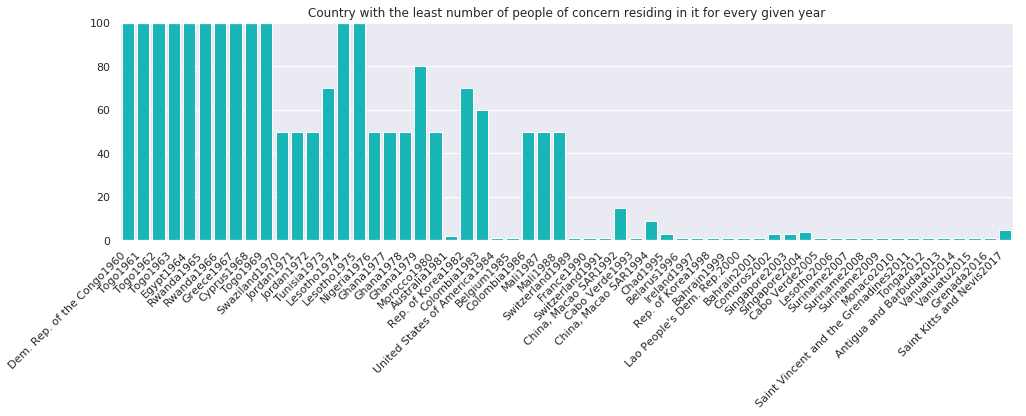

In [47]:
plot_country_lowest_total(out_residing_lowest_modified, "residing in")

 - Countries with the highest number of population of concern Originating from them:

In [48]:
out_originating_lowest_modified = [dict(data, **{'country-year':data['country'] + str(data['year'])}) for data in out_originating_lowest]

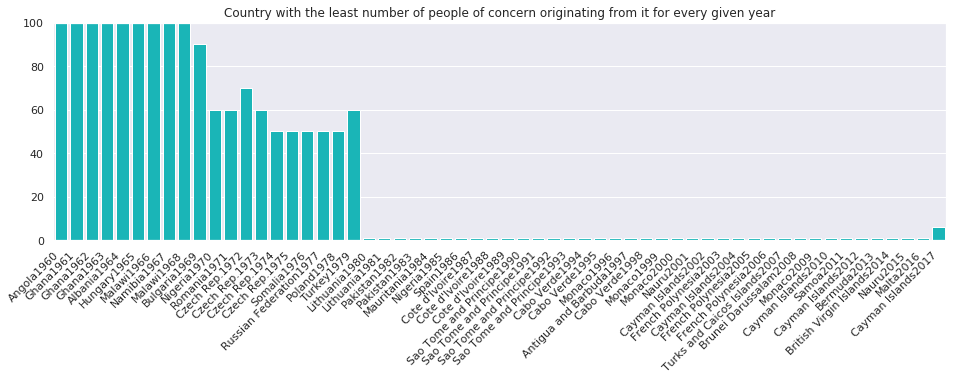

In [49]:
plot_country_lowest_total(out_originating_lowest_modified, "originating from")

### Analyse refugees and asylum seekers figures for one particular country in a given a given year

 - Given year and country of residence, obtain the number of people that request asylum and their country of origin:

In [50]:
def origin_countries_given_residence_and_year(tx,year,country_residence):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]-(b:CountryYear) "
                         "WHERE a.year={0} AND a.country={1} " 
                         "RETURN b.country AS country, "                         
                         "r.affected_refugees AS affectedRefugees, "
                         "r.affected_asylum AS affectedAsylum, "
                         "r.affected_total AS affectedTotal "
                         "ORDER BY affectedTotal DESC"
                  .format(year,country_residence))

 - Given year and country of origin, obtain the number of people that request asylum and their country of residence:

In [51]:
def origin_countries_given_origin_and_year(tx,year,country_origin):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->(b:CountryYear) "
                         "WHERE a.year={0} AND a.country={1} " 
                         "RETURN b.country as country, "
                         "r.affected_refugees AS affectedRefugees, "
                         "r.affected_asylum AS affectedAsylum, "
                         "r.affected_total AS affectedTotal "
                         "ORDER BY affectedTotal DESC".format(year,country_origin))

Calling both previous functions and ploting results for a year/country:

In [52]:
country_C2 = '"Spain"'
year_C2 = 2017
limit_C2 = 10

In [53]:
with driver.session() as session:
    countries_given_residence = session.read_transaction(origin_countries_given_residence_and_year, year_C2, country_C2).data()
    countries_given_origin = session.read_transaction(origin_countries_given_origin_and_year, year_C2, country_C2).data()

Remove None and turn into 0 for ploting:

In [54]:
def plot_country_difference_refugees_and_assylum_seekers(data_list, limit, country, year, rel_type):

    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(11)
    ax.stackplot([data['country'] for data in data_list][0:limit], 
                 [int(data['affectedAsylum'] or 0) for data in data_list][0:limit], 
                 [int(data['affectedRefugees'] or 0) for data in data_list][0:limit],
                 colors=['royalblue','darkturquoise'])
    plt.xticks(rotation=30, ha='right')
    plt.legend(('affectedAsylum', 'affectedRefugees'))
    plt.title("Countries of {2} with {0} as country of {3} for year {1}".format(country, year, rel_type.split('/')[0], rel_type.split('/')[1]))
    plt.show()

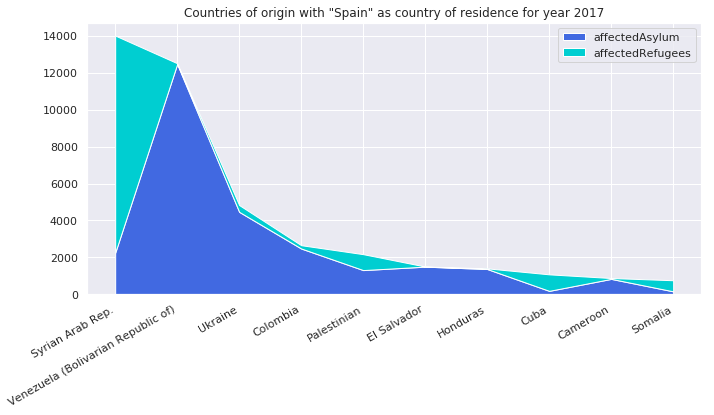

In [55]:
plot_country_difference_refugees_and_assylum_seekers(countries_given_residence, limit_C2, country_C2, year_C2, "origin/residence" )

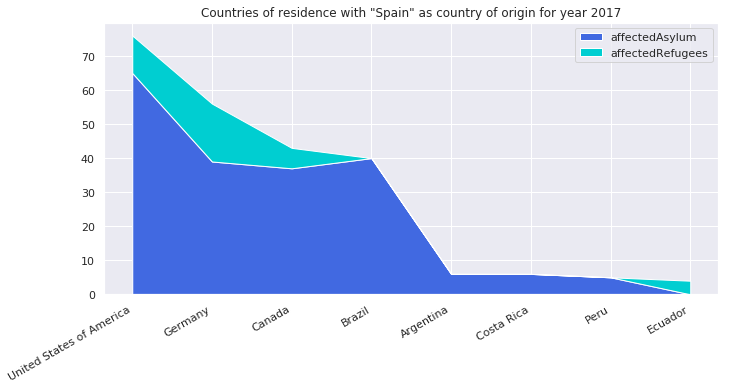

In [56]:
plot_country_difference_refugees_and_assylum_seekers(countries_given_origin, limit_C2, country_C2, year_C2, "residence/origin" )

## Difference between the number of refugees and the number of asylum seekers (accepted - pending)

In [57]:
def diff_refugee_assylum_residence_countries_given_year(tx,year):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]->() "
                    "WHERE a.year={0} " 
                    "RETURN a.country AS country, " 
                    "a.year as year, " 
                    "sum(r.affected_asylum) AS affectedAsylum, "            
                    "sum(r.affected_refugees) AS affectedRefugees, "
                    "sum(r.affected_refugees) - sum(r.affected_asylum) AS diffRefugeesAsylum "
                    "ORDER BY diffRefugeesAsylum ".format(year))

In [58]:
with driver.session() as session:
    diff_refugee_assylum = {}
    for year in years_list:
        diff_refugee_assylum[year] = session.read_transaction(diff_refugee_assylum_residence_countries_given_year, year).data()

In [59]:
mean_diff_refugeee_assylum ={}

for key in diff_refugee_assylum.keys():
    mean_diff_refugeee_assylum[key] = stats.describe([data['diffRefugeesAsylum'] for data in diff_refugee_assylum[key]]).mean

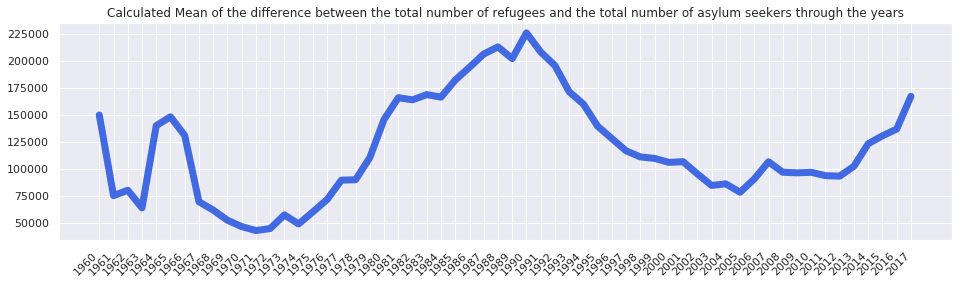

In [60]:
plt.figure(figsize=(16,4))
ax = plt.plot(list(mean_diff_refugeee_assylum.keys()), 
              list(mean_diff_refugeee_assylum.values()),
              color="royalblue",linewidth=7.0);
plt.xticks(rotation=45, ha='right');
plt.title("Calculated Mean of the difference between the total number of refugees and the total number of asylum seekers through the years");

For the last four years, get the countries with the lowest (countries with more pending cases than accepted refugees) and highest (countries with more accepted refugees thatn pending cases) difference between the total number of refugees and the total number of asylum seekers  

In [61]:
def plot_lowest_highest_diff_refugee_assylum_given_year(year, limit_slice):    
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5));
    f.tight_layout()

    diff_refugee_assylum_sliced_positive = diff_refugee_assylum[year][:limit_slice]
    diff_refugee_assylum_sliced_negative = diff_refugee_assylum[year][-limit_slice:]

    x1=[data['country'] for data in diff_refugee_assylum_sliced_positive]
    y1=[data['diffRefugeesAsylum'] for data in diff_refugee_assylum_sliced_positive]
    
    x2=[data['country'] for data in diff_refugee_assylum_sliced_negative]
    y2=[data['diffRefugeesAsylum'] for data in diff_refugee_assylum_sliced_negative]
    
    sns.barplot(x1, y1, color='darkturquoise', ax = ax1)
    sns.barplot(x2, y2, color='royalblue', ax = ax2)
    
    ax1.yaxis.set_major_formatter(ticker.EngFormatter())
    ax2.yaxis.set_major_formatter(ticker.EngFormatter())
    
    ax1.xaxis.tick_top()
    
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
    
    ax1.set_title("Difference between num. of refugees "
                  "and num. of asylum seekers in {0}".format(year))

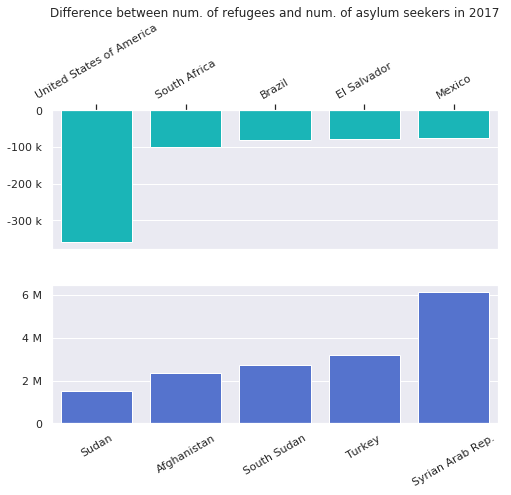

In [62]:
plot_lowest_highest_diff_refugee_assylum_given_year('2017', 5)

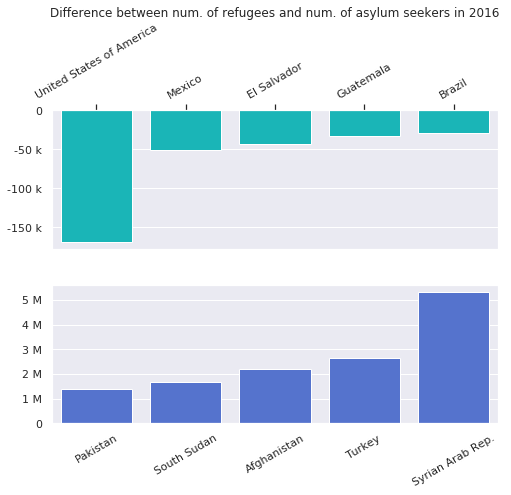

In [63]:
plot_lowest_highest_diff_refugee_assylum_given_year('2016', 5)

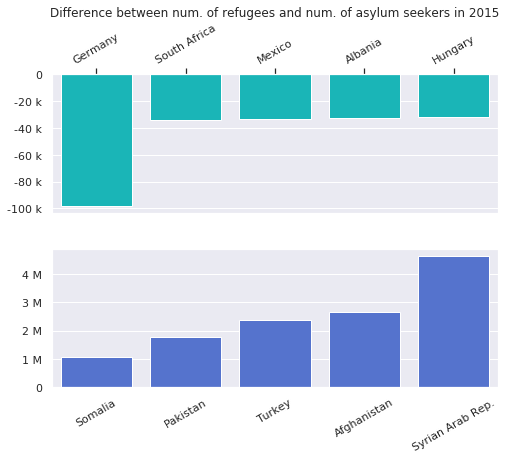

In [64]:
plot_lowest_highest_diff_refugee_assylum_given_year('2015', 5)

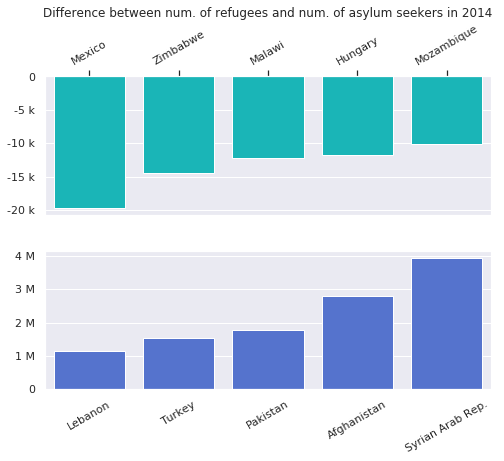

In [65]:
plot_lowest_highest_diff_refugee_assylum_given_year('2014', 5)

## Countries with the highest number of Internally Displaced People

In [66]:
def top_countries_idps_given_year(tx, year, top_number):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]-() "
                         "WHERE a.year={0} AND EXISTS(r.affected_idps) AND r.affected_idps <> 0 " 
                         "RETURN a.country as country, a.year as year, "
                         "sum(r.affected_idps) as affectedIdps, "
                         "sum(r.affected_total) as affectedTotal "
                         "ORDER BY affectedIdps DESC LIMIT {1} ".format(year, top_number)) 

In [67]:
top_number_limit_C4 = 3

In [68]:
with driver.session() as session:
    top_countries_idps = []
    for year in years_list[0::1]:
        [top_countries_idps.append(element) for element in session.read_transaction(top_countries_idps_given_year, year, top_number_limit_C4).data()]

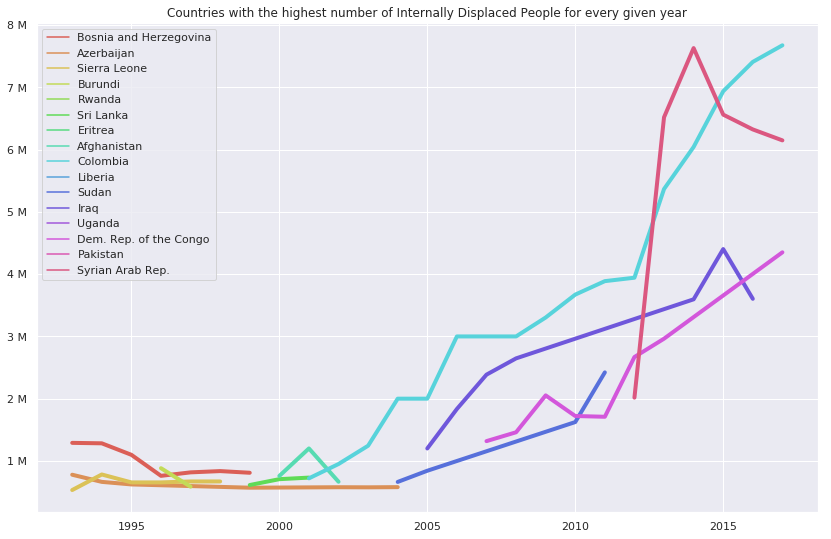

In [69]:
plt.figure(figsize=(14,9));
ax = sns.lineplot(x=[data['year'] for data in top_countries_idps],
            y=[data['affectedIdps'] for data in top_countries_idps], 
            hue=[data['country'] for data in top_countries_idps],
            palette='hls', linewidth=4)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.title("Countries with the highest number of Internally Displaced People for every given year");

## Testing how to Export a subgraph to different formats

In [70]:
def export_graph(tx,format_of_export, country, year):
    return tx.run("CALL apoc.export.{0}.query( "
                  "'MATCH p=()<-[r:RESIDE_IN]-(n) WHERE n.year={2} AND n.country={1} RETURN p', " 
                  "'../neo4j/import/prueba.{0}', {{}} )".format(format_of_export, country, year))

to graphml

In [71]:
with driver.session() as session:
    session.read_transaction(export_graph, "graphml", '"Spain"', "2017")

to json

In [72]:
with driver.session() as session:
    session.read_transaction(export_graph, "json",'"Spain"', "2017")